In [23]:
import numpy as np
import scipy as sp
import os

import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.preprocessing import binarize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
imgs = []
path = "data"
for subdir, dirs, files in os.walk(path):
    print(subdir)
    tmp = []
    for filename in files:
        if filename.endswith(".jpg"):
            img = sp.misc.imread(os.path.join(subdir, filename), flatten=True)
            tmp.append(img)
    imgs.append(tmp)
    
X = np.array(imgs[1] + imgs[2])

Y0= np.zeros((1, len(imgs[1])))
Y1 = np.ones((1, len(imgs[2])))

Y = np.hstack((Y0, Y1))

data
data\ClosedFace
data\OpenFace


In [100]:
X.shape

(2423, 100, 100)

In [3]:
print(Y0.shape)
print(Y1.shape)

(1, 1192)
(1, 1231)


In [4]:
def show_images(input, output, input_title="", output_title="", cmap='gray'):
    fig, (im_input, im_output) = plt.subplots(1, 2, figsize=(15, 35))
    im_input.imshow(input, cmap=cmap)
    im_input.set_title(input_title)
    im_input.set_axis_off()
    im_output.imshow(output, cmap=cmap)
    im_output.set_title(output_title)
    im_output.set_axis_off()
    fig.show()

In [64]:
def show_image(input, input_title="", cmap='gray'):
    fig, img = plt.subplots(1, 1, figsize=(3, 3))
    img.imshow(input, cmap=cmap)
    img.set_title(input_title)
    img.set_axis_off()
    fig.show()

In [6]:
def my_imshow(img, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.imshow(img, cmap='gray')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.yaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(size=0)

In [192]:
import pywt

In [213]:
cA, (cH, cV, cD) = pywt.dwt2(X[100], 'haar')
cA2, (cH2, cV2, cD2) = pywt.dwt2(X[-100], 'haar')

In [7]:
def r(fun):
    
    def wrapped(img):
        
        if len(img.shape) < 2:
            img = img.reshape(100, 100)
            res = fun(img)
            res = res.reshape(10000)
        else:
            res = fun(img)
        return res
    
    return wrapped

In [8]:
# Input your code here
@r
def edges(img):

    phase = np.angle(np.fft.fft2(img))
    blend = 1*(np.cos(phase) + 1j*np.sin(phase))

    blend = np.real(np.fft.ifft2(blend)) 
    #blend = blend - blend.min()
    return blend

In [9]:
def show_grid(k1, k2, X):
    m = X.shape[0]
    _, axarr = plt.subplots(k1, k2, figsize=(10, 10))

    for i in range(axarr.shape[0]):
        for j in range(axarr.shape[1]):

            n = i*k2+j
            img = X[(i%2)*(m-2*n)+n]
            axarr[i, j].set_axis_off()
            axarr[i, j].imshow(edges(img), cmap="gray")


In [10]:
X_train = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))

new_X = np.apply_along_axis(edges, 1, X_train)
new_X = new_X.reshape(X_train.shape)

In [117]:
def find_best_proj(pca, clf, X, n=25):

    black_idx = [x for x in range(1000)]
    white_idx = [2200 - x for x in black_idx]

    black_coords = np.empty((len(black_idx), n))
    white_coords = np.empty((len(white_idx), n))

    for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
        for i,idx in enumerate(indices):
            for x in range(n):
                coords[i, x] = X[idx].dot(pca.components_[x])


    tmp_X = np.concatenate((black_coords, white_coords))
    tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)

    
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty':['l1', 'l2']}

    grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=0)
    
    grid_search.fit(tmp_X, tmp_Y)
    
    clf = grid_search.best_estimator_
    
    scor = cross_val_score(clf, tmp_X, tmp_Y , cv=4, scoring="accuracy")

    return [scor.mean(), grid_search.best_estimator_.C, grid_search.best_estimator_.penalty]

In [118]:
def find_best_params(X, threshold, n_components, binar=True):
    
    bX = X
    
    if binar:
        bX = binarize(X, threshold)

    pca = PCA(n_components=n_components, svd_solver='randomized').fit(bX)
    clf = LogisticRegression()
    res = find_best_proj(pca, clf, bX, n=n_components)
    return np.array([res[0], threshold, n_components, res[1], res[2]])

In [119]:
T = [0.01, 0.02, 0.03]
components = [100, 150, 200]

In [120]:
acc = []
for threshold in T:
    for n_components in components:
        
        acc.append(find_best_params(new_X, threshold, n_components))
        
acc = np.array(acc)

In [121]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.758', '0.01', '100', '1', 'l1'], 
      dtype='<U32')

In [124]:
apply_method(new_X, LogisticRegression(penalty='l1', C=1), 0.01, 100)

Final Accuracy:  0.546


ValueError: bad input shape (500, 2)

In [133]:
def find_best_proj_ada(pca, clf, params, X, n=25):

    black_idx = [x for x in range(1000)]
    white_idx = [2200 - x for x in black_idx]

    black_coords = np.empty((len(black_idx), n))
    white_coords = np.empty((len(white_idx), n))

    for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
        for i,idx in enumerate(indices):
            for x in range(n):
                coords[i, x] = X[idx].dot(pca.components_[x])


    tmp_X = np.concatenate((black_coords, white_coords))
    tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)

    
    

    grid_search = GridSearchCV(clf, param_grid=params, verbose=1, n_jobs=4)
    
    grid_search.fit(tmp_X, tmp_Y)
    
    clf = grid_search.best_estimator_
    
    scor = cross_val_score(clf, tmp_X, tmp_Y , cv=4, scoring="accuracy")

    return [scor.mean()]

In [134]:
def find_best_params_clf(X, clf, params, threshold, n_components, binar=True):
    
    bX = X
    
    if binar:
        bX = binarize(X, threshold)

    pca = PCA(n_components=n_components, svd_solver='randomized').fit(bX)
    clf = clf()
    res = find_best_proj_ada(pca, clf, params, bX, n=n_components)
    return np.array([res[0], threshold, n_components])

In [135]:
acc = []
acc2 = []
params = {"n_estimators": np.arange(50,100,10)}

for n_components in components:
    acc2.append(find_best_params_clf(X_train, AdaBoostClassifier, params, 0, n_components, binar=False))
    for threshold in T:
        acc.append(find_best_params_clf(new_X, AdaBoostClassifier, params, threshold, n_components))                    
        print("done")
        
acc = np.array(acc)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.5s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.5s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.5s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    5.6s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    7.7s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    7.8s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    7.9s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    7.8s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   10.4s finished


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   10.7s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   10.2s finished


done
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   10.4s finished


done


In [143]:
i = np.argmax(acc2, axis=0)[0]
print(acc2[i])

i = np.argmax(acc, axis=0)[0]
print(acc[i])

[   0.741    0.     150.   ]
[  7.14000000e-01   1.00000000e-02   1.00000000e+02]


In [24]:
apply_method(new_X, clf, 0.01, 200)

KeyboardInterrupt: 

In [136]:
acc_svc = []
acc_svc2 = []
params = {'C':np.arange(1,5)}

for n_components in components:
    acc_svc2.append(find_best_params_clf(X_train, SVC, params, 0, n_components, binar=False))
    for threshold in T:
        acc_svc.append(find_best_params_clf(new_X, SVC, params, threshold, n_components))                    
        print("done")
        
acc_svc = np.array(acc_svc)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.8s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.3s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.9s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    1.9s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    3.4s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.9s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.4s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.4s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    4.1s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    3.5s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.8s finished


done
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    2.9s finished


done


In [144]:
i = np.argmax(acc_svc2, axis=0)[0]
print(acc_svc2[i])

i = np.argmax(acc_svc, axis=0)[0]
print(acc_svc[i])

[   0.5    0.   100. ]
[  7.72000000e-01   1.00000000e-02   1.50000000e+02]


In [137]:
acc_gb = []
acc_gb2 = []
params = {'n_estimators':np.arange(100, 1000, 50)}

for n_components in components:
    acc_gb2.append(find_best_params_clf(X_train, GradientBoostingClassifier, params, 0, n_components, binar=False))
    for threshold in T:
        acc_gb.append(find_best_params_clf(new_X, GradientBoostingClassifier, params, threshold, n_components))                    
        print("done")
        
acc_gb = np.array(acc_gb)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.5min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.1s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.5min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.4s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.5min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   57.4s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.5min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.2min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.2min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.2min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.2min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.9min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.9min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.9min finished


done
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.9min finished


done


In [145]:
i = np.argmax(acc_gb2, axis=0)[0]
print(acc_gb2[i])

i = np.argmax(acc_gb, axis=0)[0]
print(acc_gb[i])

[   0.791    0.     150.   ]
[  7.39000000e-01   1.00000000e-02   1.00000000e+02]


In [20]:
clf = SVC(C=4, probability=True )

In [26]:
new_X.shape

(2423, 10000)

In [21]:
def apply_method(X, clf, threshold, n):
    
    bX = binarize(X, threshold)
    pca = PCA(n_components=n, svd_solver='randomized').fit(bX)
    
    black_idx = [x for x in range(1000)]
    white_idx = [2200 - x for x in black_idx]

    black_coords = np.empty((len(black_idx), n))
    white_coords = np.empty((len(white_idx), n))

    for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
        for i,idx in enumerate(indices):
            for x in range(n):
                coords[i, x] = X[idx].dot(pca.components_[x])


    tmp_X = np.concatenate((black_coords, white_coords))
    tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)


    x_train, x_test, y_train, y_test = train_test_split(tmp_X, tmp_Y)
    clf.fit(x_train, y_train)
    
    print('Final Accuracy: ', clf.score(x_test, y_test))
    predict_prob = clf.predict_proba(x_test)
    precision, recall = precision_recall_curve(y_test, predict_prob)
    plt.title("Precision-Recall Curve")
    plt.plot(recall, precision)
    plt.show()


In [25]:
apply_method(new_X, clf, 0.01, 200)

Final Accuracy:  0.48


ValueError: bad input shape (500, 2)

## ShahRukh pyramids

In [295]:
X_50_open = np.load('./Np_files/open_50.npy')
X_25_open = np.load('./Np_files/open_25.npy')
X_13_open = np.load('./Np_files/open_13.npy')
X_7_open = np.load('./Np_files/open_7.npy')
open_target = np.ones(X_50_open.shape[0])

X_50_close = np.load('./Np_files/close_50.npy')
X_25_close = np.load('./Np_files/close_25.npy')
X_13_close = np.load('./Np_files/close_13.npy')
X_7_close = np.load('./Np_files/close_7.npy')
close_target = np.zeros(X_50_close.shape[0])

targets = np.concatenate((open_target, close_target))

X_50 = np.concatenate((X_50_open, X_50_close))
X_25 = np.concatenate((X_25_open, X_25_close))
X_13 = np.concatenate((X_13_open, X_13_close))
X_7 = np.concatenate((X_7_open, X_7_close))

# 50

In [290]:
acc = []

for n_components in components:

    acc.append(find_best_params(X_50, 0, n_components, binarize=False))
        
acc = np.array(acc)

In [291]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.732', '0', '250', '1', 'l2'], 
      dtype='|S32')

# 25

In [292]:
acc = []

for n_components in components:

    acc.append(find_best_params(X_25, 0, n_components, binarize=False))
        
acc = np.array(acc)

In [293]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.785', '0', '200', '10', 'l1'], 
      dtype='|S32')

# 13

In [296]:
acc = []
for n_components in components:

    acc.append(find_best_params(X_13, 0, n_components, binarize=False))
        
acc = np.array(acc)

In [297]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.8025', '0', '250', '10', 'l2'], 
      dtype='|S32')

# 7

In [300]:
acc = []
for n_components in components[:2]+[147]:

    acc.append(find_best_params(X_7, 0, n_components, binarize=False))
        
acc = np.array(acc)

In [301]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.787', '0', '147', '1000', 'l2'], 
      dtype='|S32')

# Ivan autocontrast+hog

In [71]:
from operator import itemgetter
from skimage.feature import hog

def autocontrast(image, white_perc=0.2, black_perc = 0.2):
    img = image
    sorted_img = sorted(np.ndenumerate(img), key=itemgetter(1))
    pixels_number = len(sorted_img)
    black_border = float(black_perc)*pixels_number
    white_border = float(white_perc)*pixels_number
    for e in enumerate(sorted_img):
        if (int(round(black_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != sorted_img[e[0] + 1][1])):
            black_threshold_number = e[0]
            break
        else:
            img[e[1][0]] = 0

    reversed_sorted_img = list(reversed(sorted_img))
    for e in enumerate(reversed_sorted_img):
        if (int(round(white_border)) <= e[0] and 
           (e[0] == 0 or e[0] == pixels_number - 1 or img[e[1][0]] != reversed_sorted_img[e[0] + 1][1])):
            white_threshold_number = pixels_number - e[0] - 1
            break
        else:
            img[e[1][0]] = 255

    black_threshold = sorted_img[black_threshold_number][1]
    white_threshold = sorted_img[white_threshold_number][1]

    for e in enumerate(sorted_img[black_threshold_number : white_threshold_number + 1]):
        img[e[1][0]] = (img[e[1][0]] - black_threshold)*255 / float(white_threshold - black_threshold)

    return img


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


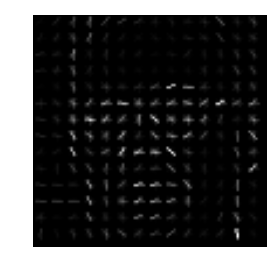

In [116]:
img = sp.misc.imread("1 (1).jpg", flatten=True)
img, img2 = hog(img, orientations=8, pixels_per_cell=(7, 7), cells_per_block=(1, 1), visualise=True)
show_image(img2)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


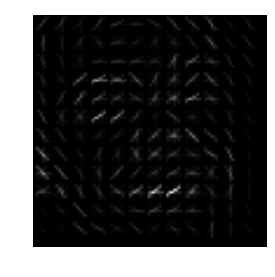

In [148]:
def get_df_faces(x, k1=100, k2=100):

    img = x.reshape(k1, k2)
    
    autocontrast(img, white_perc=0., black_perc = 0.)
    img = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=False)
    
    return img

In [149]:
X_df = np.apply_along_axis(get_df_faces, 1, X_train)

In [150]:
X_df.shape

(2423, 38088)

In [152]:
acc = []
for n_components in components:

    acc.append(find_best_params(X_df, 0, n_components, binar=False))
        
acc = np.array(acc)

In [153]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.8705', '0', '200', '1', 'l1'], 
      dtype='<U32')

In [330]:
i = np.argmax(acc, axis=0)[0]
acc[i]

array(['0.882', '0', '150', '0.1', 'l2'], 
      dtype='|S32')

In [155]:
clf = LogisticRegression(C=0.1)
apply_method2(X_df, clf, 0, 150)

Final Accuracy:  0.888


ValueError: bad input shape (500, 2)

In [162]:
clf = LogisticRegression(C=0.1)

n = 150
bX = X_df
pca = PCA(n_components=n, svd_solver='randomized').fit(bX)

black_idx = [x for x in range(1000)]
white_idx = [2200 - x for x in black_idx]

black_coords = np.empty((len(black_idx), n))
white_coords = np.empty((len(white_idx), n))

for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
    for i,idx in enumerate(indices):
        for x in range(n):
            coords[i, x] = X_df[idx].dot(pca.components_[x])


tmp_X = np.concatenate((black_coords, white_coords))
tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)


x_train, x_test, y_train, y_test = train_test_split(tmp_X, tmp_Y)
clf.fit(x_train, y_train)

%timeit clf.predict(x_test)

print('Final Accuracy: ', clf.score(x_test, y_test))

10000 loops, best of 3: 166 µs per loop
Final Accuracy:  0.89


In [165]:
img = X_train[0].reshape(100, 100)
    
%timeit autocontrast(img, white_perc=0., black_perc = 0.)
%timeit hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(3, 3), visualise=False)
    

10 loops, best of 3: 53.8 ms per loop
100 loops, best of 3: 9.64 ms per loop


In [164]:
%timeit pca.transform(X_df[0])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecati

10 loops, best of 3: 23.5 ms per loop


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprecati

In [155]:
clf = LogisticRegression(C=0.1)
apply_method2(X_df, clf, 0, 150)

Final Accuracy:  0.888


ValueError: bad input shape (500, 2)

In [158]:
def apply_method2(X, clf, threshold, n):
    
    bX = X
    pca = PCA(n_components=n, svd_solver='randomized').fit(bX)
    
    black_idx = [x for x in range(1000)]
    white_idx = [2200 - x for x in black_idx]

    black_coords = np.empty((len(black_idx), n))
    white_coords = np.empty((len(white_idx), n))

    for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
        for i,idx in enumerate(indices):
            for x in range(n):
                coords[i, x] = X[idx].dot(pca.components_[x])


    tmp_X = np.concatenate((black_coords, white_coords))
    tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)


    x_train, x_test, y_train, y_test = train_test_split(tmp_X, tmp_Y)
    clf.fit(x_train, y_train)
    
    %timeit clf.predict(x_test)
    
    print('Final Accuracy: ', clf.score(x_test, y_test))


In [28]:
def pca_transform(X, n_components):

    pca = PCA(n_components=n_components, svd_solver='randomized').fit(X)
    
    
    black_idx = [x for x in range(1000)]
    white_idx = [2200 - x for x in black_idx]

    black_coords = np.empty((len(black_idx), n_components))
    white_coords = np.empty((len(white_idx), n_components))

    for coords, indices in ((black_coords, black_idx), (white_coords, white_idx)):
        for i,idx in enumerate(indices):
            for x in range(n_components):
                coords[i, x] = X[idx].dot(pca.components_[x])


    tmp_X = np.concatenate((black_coords, white_coords))
    tmp_Y = [0]*len(black_idx) + [1]*len(white_idx)
    return pca, tmp_X, tmp_Y

    #scor = cross_val_score(clf, tmp_X, tmp_Y , cv=10, scoring="accuracy")

    #return [scor.mean(), grid_search.best_estimator_.C, grid_search.best_estimator_.penalty]

In [67]:
def pca_plot(pca, k1, k2, n=25):
   
    show_image(pca.mean_.reshape(k2, k1)*1.0)
    plt.title('(Pixel-wise) mean face');

    eigenfaces = pca.components_[:n].reshape(5, 5, k2, k1)
    titles = np.array(['#%d' % (i+1,) \
                       for i,v in enumerate(pca.explained_variance_ratio_[:25])]).reshape(5, 5)

    _, axarr = plt.subplots(5, 5, figsize=(20, 20))

    for x in range(5):
        for y in range(5):
            my_imshow(eigenfaces[x,y], axarr[x,y])
            axarr[x,y].set_title(titles[x,y], fontsize=10)

    plt.suptitle('25 principal components', size=20)
    plt.show()

In [68]:
['0.7635', '0.02', '200', '0.1', 'l1']

bX = binarize(new_X, 0.01)
pca, tmp_X, tmp_Y = pca_transform(bX, 200)

In [61]:
m = np.array(pca.mean_, dtype=float)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


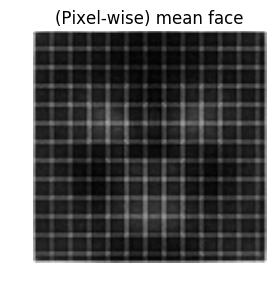

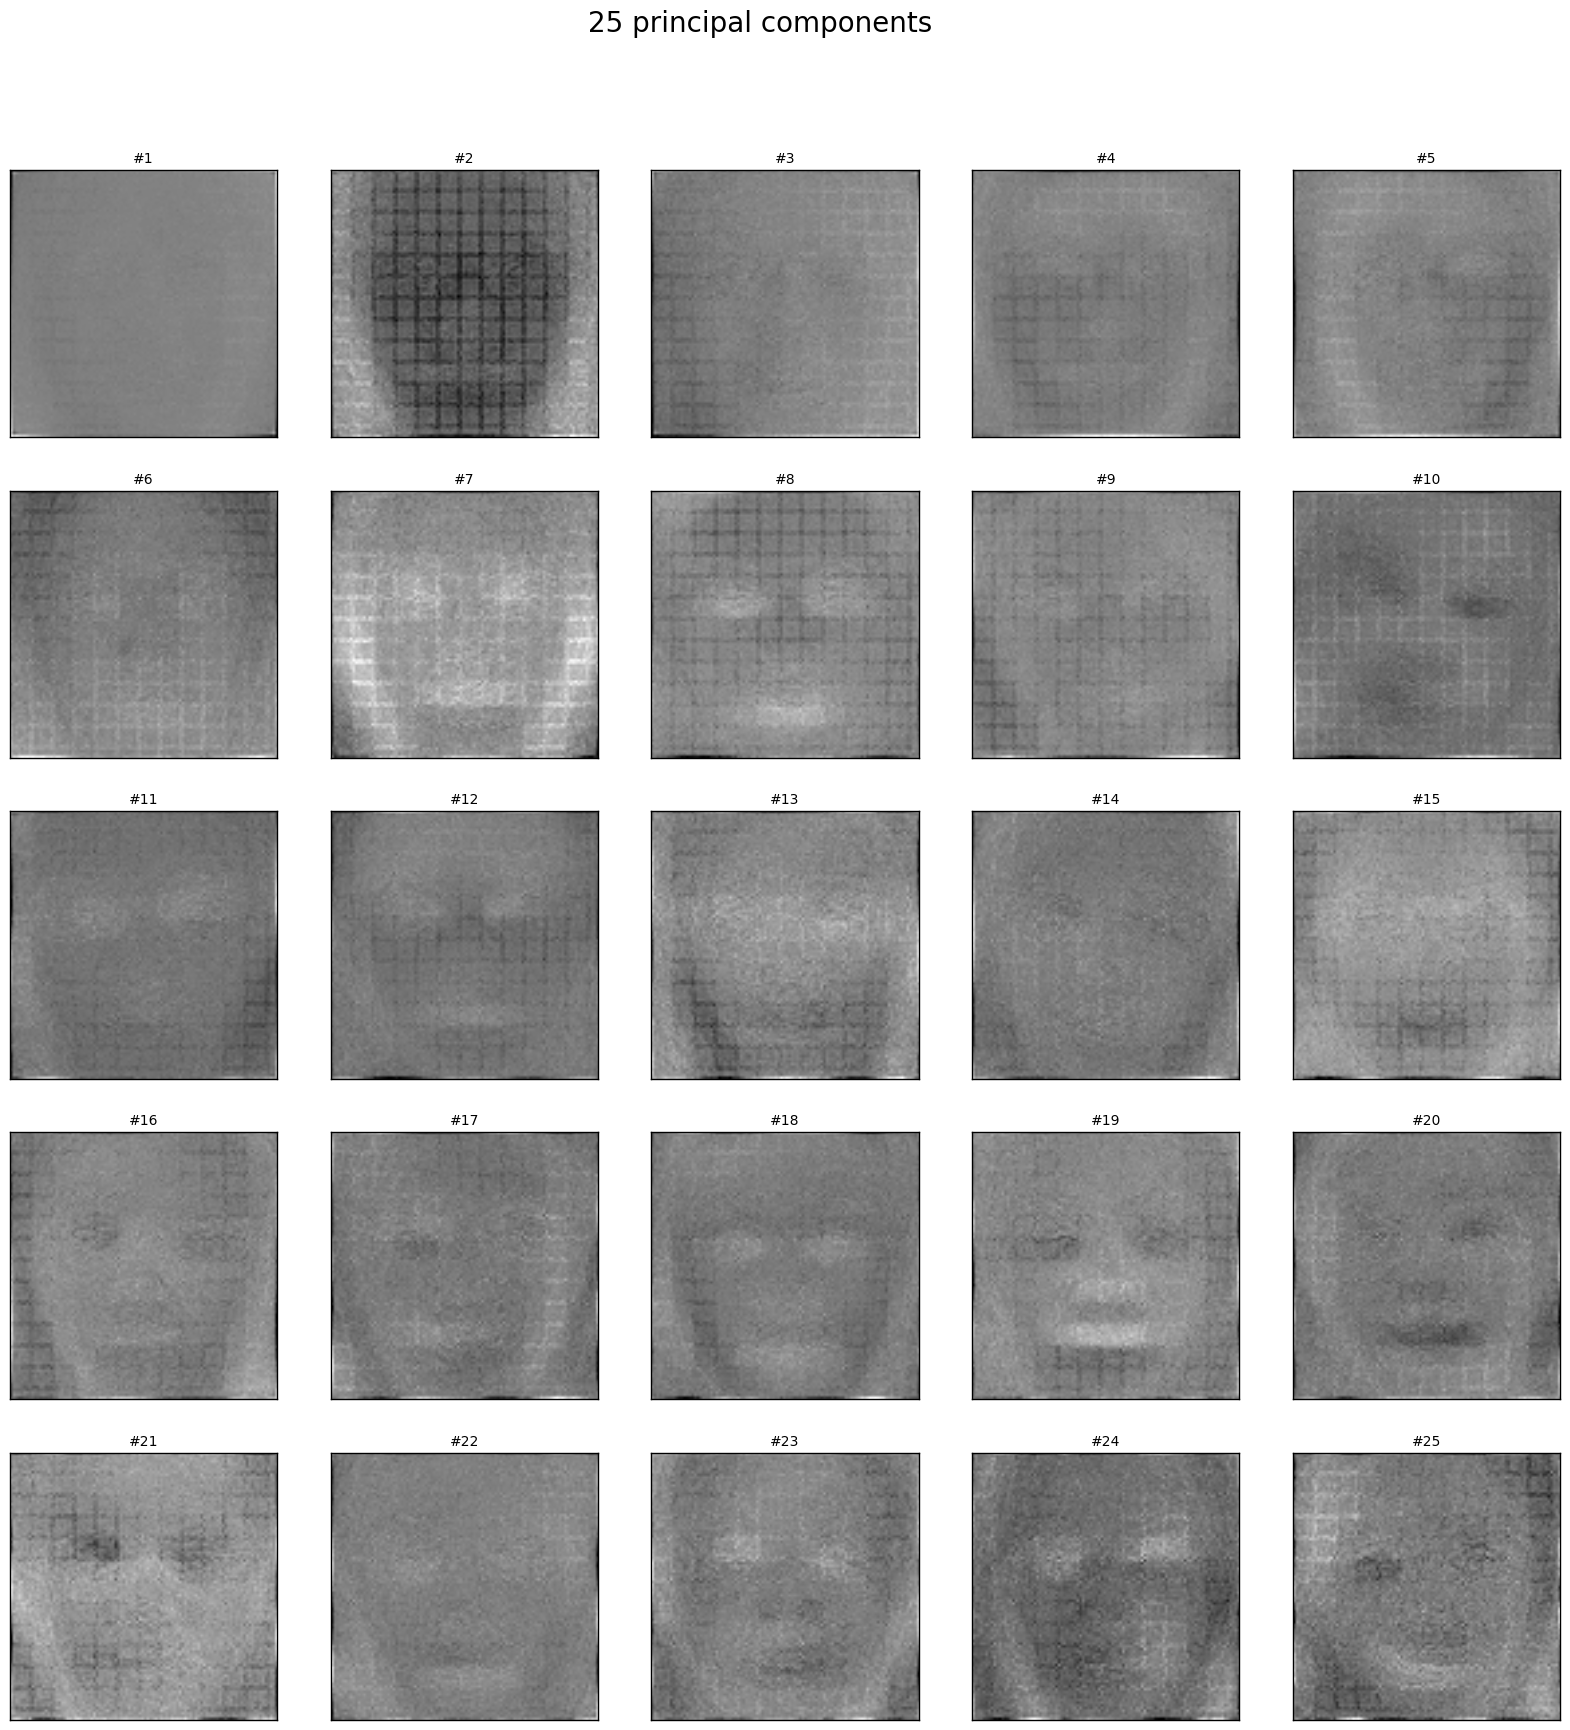

In [69]:
pca_plot(pca, 100, 100)

In [53]:
clf = LogisticRegression(C=0.1, penalty='l2')

pca, tmp_X, tmp_Y = pca_transform(new_X, 100, 100)

TypeError: pca_transform() takes 2 positional arguments but 3 were given

In [242]:
tmp_X.shape

(2000, 100)

In [243]:
scor = cross_val_score(clf, tmp_X, tmp_Y , cv=10, scoring="accuracy")

In [244]:
scor.mean()

0.87349999999999994

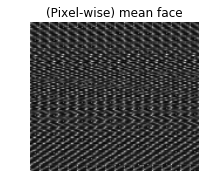

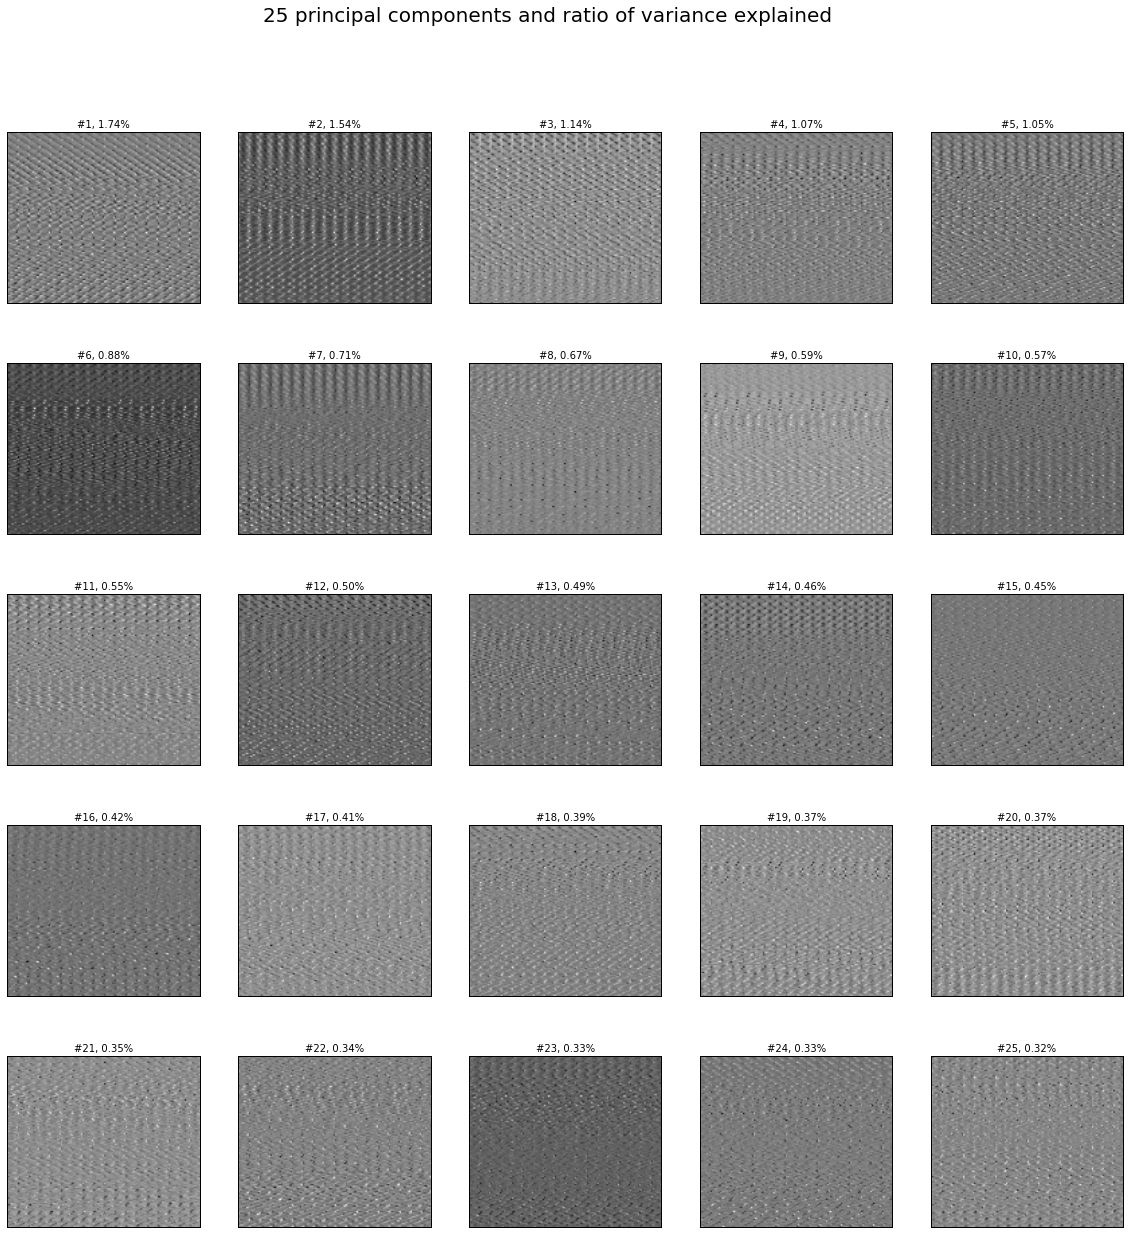

In [258]:
pca_plot (pca)

In [ ]:

bX = binarize(new_X, threshold
show_grid(5, 5, bX.reshape(-1, 100, 100))

n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized').fit(bX)

show_image(pca.mean_.reshape(100, 100))
plt.title('(Pixel-wise) mean face');

eigenfaces = pca.components_[:25].reshape(5, 5, 100, 100)
titles = np.array(['#%d, %.2f%%' % (i+1,v*100) \
                   for i,v in enumerate(pca.explained_variance_ratio_[:25])]).reshape(5, 5)

_, axarr = plt.subplots(5, 5, figsize=(10, 10))

for x in range(5):
    for y in range(5):
        my_imshow(eigenfaces[x,y], axarr[x,y])
        axarr[x,y].set_title(titles[x,y], fontsize=10)

plt.suptitle('25 principal components and ratio of variance explained', size=20)

clf = LogisticRegression()
acc.append(np.array([find_best_proj(pca, clf, bX, n=n_components), threshold, n_components]))


In [ ]:
scores = []
for method in methods:
    scores = cross_val_score(method, X_train, *Y , cv=10, scoring="accuracy")
    scores.append([scores.mean(), scores.std()])

In [ ]:
errors = []
kernelRidge = kernel_ridge.KernelRidge(kernel = 'rbf', alpha=0.2, gamma = 0.2)
for a in alphas:
    print ('.',)
    kernelRidge.set_params(alpha=a)
    kernelRidge.fit(X_train, y_train)
    errors.append(mean_squared_error(y_test, kernelRidge.predict(X_test)))